# 2023 November Processing Template
Duncan

In [28]:
%load_ext autoreload
%autoreload 2

import os
from copy import deepcopy

import skimage
import numpy as np
import pandas as pd
#import seaborn as sns

from htbam_analysis.processing import chip
from htbam_analysis.processing import experiment as exp
from htbam_analysis.processing import chipcollections as collections

import matplotlib.pyplot as pl
#%matplotlib inline
from matplotlib.widgets import Button, Slider
import time
%config InlineBackend.figure_format = 'svg'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Establish experiment and pinlist

In [2]:
root = '/Users/duncanmuir/Desktop/20231114_std_curve_test_data_duncan/'
description = 'standard_curve_debugging'
operator = 'DFM'

e = exp.Experiment(description, root, operator)

INFO     Experiment Initialized | Description: standard_curve_debugging, Operator: DFM


In [5]:

# Making a fake pinlist
#block 1 is the left side of the image, but right side of the device
block_descriptions = {1: 'Mac1_WT', 2: 'Mac1_WT', 3: 'Mac1_Mut', 4: 'Mac1_Mut'}
def get_block(c):
    return ((c // 8) + 1)
#creating a pin list
pinlist_dict = []
for c in range(32):
    for r in range(56):
        block = get_block(c)
        mutant = block_descriptions[block]
        pinlist_dict.append({'Indices': (c + 1, r + 1), 'MutantID': mutant})
pinlist_df = pd.DataFrame(pinlist_dict)
pinlist_path = '{}/data_analysis/20230208_pinlist.csv'.format(root)
pinlist_df.to_csv(pinlist_path, index=False)

In [6]:
pinlist = e.read_pinlist('{}/data_analysis/20230208_pinlist.csv'.format(root))
pinlist.head(5)

Indices MutantID
x y                 
1 1  (1, 1)  Mac1_WT
  2  (1, 2)  Mac1_WT
  3  (1, 3)  Mac1_WT
  4  (1, 4)  Mac1_WT
  5  (1, 5)  Mac1_WT

## 2. Add devices and corners

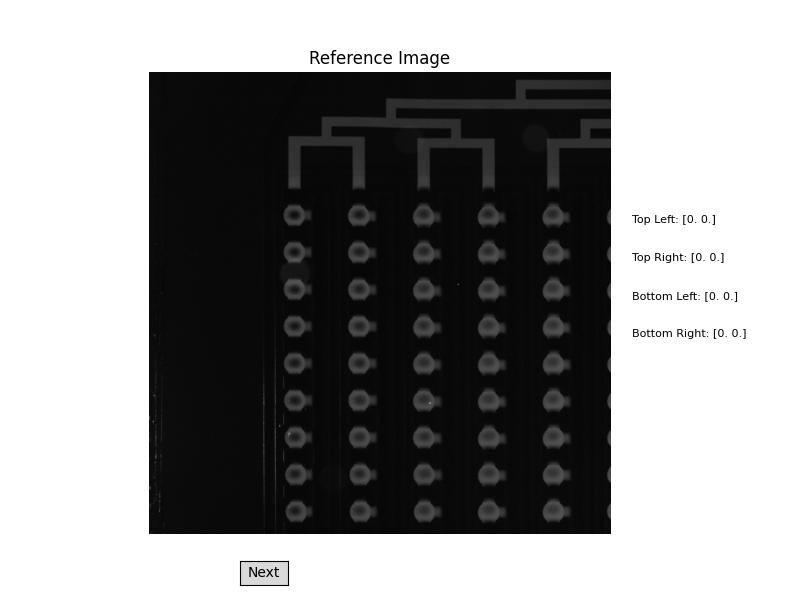

0
1
2
3
0
1
2
3
0
1


In [ ]:
%matplotlib widget
class CornerPicker:
    def __init__(self, img):
        self.img_data = skimage.io.imread(img)
        self.corner_imgs = [self.img_data[:int(self.img_data.shape[0] * 0.2), :int(self.img_data.shape[1] * 0.2)],
                           self.img_data[:int(self.img_data.shape[0] * 0.2), int(self.img_data.shape[1] * 0.8):],
                            self.img_data[int(self.img_data.shape[0] * 0.8):, :int(self.img_data.shape[1] * 0.2)],
                            self.img_data[int(self.img_data.shape[0] * 0.8):, int(self.img_data.shape[1] * 0.8):]]
        self.img_index = 0
        self.curr_img = self.corner_imgs[self.img_index]
        self.corner_chamber_coords = np.zeros((4, 2))
        
    def show(self):
        # Define initial parameters
        init_max_intensity = max(self.curr_img.flatten())

        # Create the figure and the line that we will manipulate
        self.fig = pl.figure(figsize=(8, 6))
        self.ax = self.fig.add_subplot(111)
        
        # adjust pixel coordinates to account for the fact that we are plotting a subset of the image
       
        self.img_plot = pl.imshow(self.curr_img, cmap='gray')
       
        #pl.ion()
        pl.axis('off')
        pl.title('Reference Image')

        # adjust the main plot to make room for the slider and coord list
        pl.subplots_adjust(left=0.05)

        ##############################
        ## SLIDER
        ##############################

        # # Make a vertically oriented slider to control the max intensity.
        # self.ax_int = self.fig.add_axes([0.1, 0.25, 0.0225, 0.63])
        # self.int_slider = Slider(
        #     ax=self.ax_int,
        #     label="max intensity",
        #     valmin=min(self.curr_img.flatten()),
        #     valmax=max(self.curr_img.flatten()),
        #     valstep=100,
        #     valinit=init_max_intensity,
        #     orientation="vertical"
        # )

       
        # def f(img, max_intensity):
        #     img = deepcopy(img)
        #     return np.clip(img, a_min=min(img.flatten()), a_max=max_intensity)
        
        # # The function to be called anytime a slider's value changes
        # def update(val):
        #     self.img_plot.set_data(f(self.curr_img, self.int_slider.val))
        #     self.img_plot.set_clim(vmin=min(self.curr_img.flatten()), vmax=self.int_slider.val)
        #     self.fig.canvas.draw_idle()


        # # register the update function with each slider
        # self.int_slider.on_changed(update)

        ##############################
        ## RESET BUTTON
        ##############################

        # # Create a `matplotlib.widgets.Button` to reset the sliders to initial values.
        # self.resetax = self.fig.add_axes([0.8, 0.025, 0.1, 0.04])
        # self.reset_button = Button(self.resetax, 'Reset', hovercolor='0.975')

        # def reset(event):
        #     self.int_slider.reset()

        # self.reset_button.on_clicked(reset)

        ##############################
        ## NEXT BUTTON
        ##############################

        self.nextax = self.fig.add_axes([0.3, 0.025, 0.06, 0.04])
        self.next_button = Button(self.nextax, 'Next', hovercolor='0.975')

        def next_img(event):
            #self.int_slider.reset()
            print(self.img_index)
            self.img_index += 1
            if self.img_index > 3:
                self.img_index = 0
            self.curr_img = self.corner_imgs[self.img_index]
            self.img_plot.set_data(self.curr_img)
            #self.img_plot.set_clim(vmin=min(self.curr_img.flatten()), vmax=self.int_slider.val)
            self.fig.canvas.draw()
            time.sleep(0.1)

        self.next_button.on_clicked(next_img)

        ##############################
        ## COORD SAVE BUTTON
        ##############################

        # displat the current corner chamber coordinates on the right side of the plot

        self.ax_coords = self.fig.add_axes([0.78, 0.25, 0.1, 0.63])
        self.ax_coords.axis('off')
        #self.ax_coords.set_title('Corners')
        self.ax_coords.text(0.1, 0.6, 'Top Left: ' + str(self.corner_chamber_coords[0, :]), fontsize=8)
        self.ax_coords.text(0.1, 0.5, 'Top Right: ' + str(self.corner_chamber_coords[1, :]), fontsize=8)
        self.ax_coords.text(0.1, 0.4, 'Bottom Left: ' + str(self.corner_chamber_coords[2, :]), fontsize=8)
        self.ax_coords.text(0.1, 0.3, 'Bottom Right: ' + str(self.corner_chamber_coords[3, :]), fontsize=8)
        
        # when a user clicks on the image, save the coordinates of the click
        def onclick(event):
            if event.xdata != None and event.ydata != None and event.inaxes == self.ax:
                self.corner_chamber_coords[self.img_index, :] = [int(event.xdata), int(event.ydata)]

                # redraw the coordinates
                self.ax_coords.clear()
                self.ax_coords.axis('off')

                self.ax_coords.text(0.1, 0.6, 'Top Left: ' + str(self.corner_chamber_coords[0, :]), fontsize=8)
                self.ax_coords.text(0.1, 0.5, 'Top Right: ' + str(self.corner_chamber_coords[1, :]), fontsize=8)
                self.ax_coords.text(0.1, 0.4, 'Bottom Left: ' + str(self.corner_chamber_coords[2, :]), fontsize=8)
                self.ax_coords.text(0.1, 0.3, 'Bottom Right: ' + str(self.corner_chamber_coords[3, :]), fontsize=8)
                

                self.fig.canvas.draw()
        
        self.fig.canvas.mpl_connect('button_press_event', onclick)
        
        pl.show()

cp = CornerPicker('/Users/duncanmuir/Desktop/20231114_std_curve_test_data_duncan/standard/Analysis/StitchedImg_1000_5_500.tif')
cp.show()

        

In [13]:
# Top left, top right, bottom left, bottom right
#d1_corners = ((529, 433),(6808,425),(558,6867),(6865,6842)) #Each physical chip is a device, these are the center of the reaction chambers. 
d3_corners = ((452, 450),(6723,441),(472,6817),(6742,6800)) 
#d3_corners = ((553, 442),(3833,461),(577,6891),(6868,6849)) 
#Do this in imageJ, put your cursor over the reaction chambers and copy over
d3 = exp.Device('s1', 'd3', (32, 56), pinlist, d3_corners)
#d2 = exp.Device('s4', 'd2', (32, 56), pinlist, d2_corners)
#d3 = exp.Device('s4', 'd3', (32, 56), pinlist, d3_corners)

### Non-standard chamber-finding parameters

In [14]:
#chip.Stamp.circlePara1Index = 30
#chip.Stamp.circlePara2Index = 15

print('Old Chamber Radius: {} pixels'.format(chip.Stamp.chamberrad))
chip.Stamp.chamberrad = 32#33 in 2x2
print('New Chamber Radius: {} pixels'.format(chip.Stamp.chamberrad))

Old Chamber Radius: 32 pixels
New Chamber Radius: 32 pixels


## 3. Execute button analyses

#### Quantify egfp fluorescence on buttons

##### Load

In [6]:
# Stitched image path
p3 = '/Volumes/DuncanSSD/20230331/button_quant/20230401-095714-d2_egfp-quant_pre-MM_egfp_500_Sola_2x2_Kinetix-DynamicRange_4x/egfp/StitchedImages/BGSubtracted_StitchedImg_500_egfp_0.tif'
#p2 = '/Volumes/T7/20221103/button_quant/20221103-182701-d2_mat2a_wash_egfp_500_Sola_4x4_Kinetix-DynamicRange_4x/egfp/StitchedImages/BGSubtracted_StitchedImg_500_egfp_0.tif'
#p3 = '/Volumes/Samsung_T5/211210/20211212-182846-d3_tmTrpB_egfp_500_W2/egfp/StitchedImages/BGSubtracted_StitchedImg_500_egfp_0.tif'

# Prepare ChipQuant object
d3_GFPQuant = collections.ChipQuant(d3, 'ButtonReference')
#d2_GFPQuant = collections.ChipQuant(d2, 'ButtonReference')
#d3_GFPQuant = collections.ChipQuant(d3, 'ButtonReference')

# Load image into memory
d3_GFPQuant.load_file(p3, 'egfp', 500)
#d2_GFPQuant.load_file(p2, 'egfp', 500)
#d3_GFPQuant.load_file(p3, 'egfp', 500)



##### Process

In [13]:
# Find buttons, extract intensity attributes
d3_GFPQuant.process()
#d2_GFPQuant.process()
#d3_GFPQuant.process()

# Summarize attributes as a pandas dataframe
quant_report1 = d3_GFPQuant.summarize()
#quant_report2 = d2_GFPQuant.summarize()
#quant_report3 = d3_GFPQuant.summarize()


Finding Buttons: 100%|██████████| 1792/1792 [03:04<00:00,  9.70it/s]


##### Save Summary/Image

In [14]:
quant_report1.to_csv('/Users/duncanmuir/code/pinney-lab/lab-notebook-muir/data/adk_on-chip/adk_orthologs_egfp_summary.csv')
#quant_report2.to_csv('{}/data_analysis/button_summary_d2.csv'.format(root))
#quant_report3.to_csv('/Volumes/Samsung_T5/211210/button_summary_d3.csv')


d3_GFPQuant.save_summary_image()
#d2_GFPQuant.save_summary_image()
#d3_GFPQuant.save_summary_image()

## 4. Standards

In [9]:
#define standard corners (if these are the same as your device above, you don't need to)
# Top left, top right, bottom left, bottom right
#d2_std_corners = ((229, 237),(3355,248),(218,3425),(3343,3433))  #Each physical chip is a device, these are the center of the reaction chambers. 
#Do this in imageJ, put your cursor over the reaction chambers and copy over
d3_std = exp.Device('s1', 'd3', (32, 56), pinlist, d3_corners)

In [41]:
# Create a standard series, load stitched images
p_d3 = '/Volumes/T7/20221208_Mat2a_analysis.v2/20221202_tracy/standard_curve/Analysis_resized/dapi/StitchedImages'
d2_PBP = collections.StandardSeries(d2_std, 'PBP')
d2_PBP.load_files(p_d2, 'PBP', 100)

In [43]:
d2_PBP.save_summary()
d2_PBP.save_summary_images()

## 5. Chamber Reference

In [15]:
#code is having a hard time finding chambers in the standard curve (perhaps because it was resized?), so using this image as a reference

d3_ChamberRef = collections.ChipQuant(d3, 'Chamber_Ref')
chamber_ref = '/Users/duncanmuir/Desktop/20231114_std_curve_test_data_duncan/standard/Analysis/StitchedImg_1000_5_500.tif'
d3_ChamberRef.load_file(chamber_ref, 'fura', 1000)

In [16]:
d3_ChamberRef.process(mapped_features = 'chamber', coerce_center = False)


In [17]:
d3_ChamberRef.save_summary_image(feature_type = 'chamber')


### 6. Kinetics

In [9]:
# Assay Series Descriptions & Object
from pathlib import Path 
parent = Path('/Volumes/DuncanSSD/20230331/kinetics/')

kinetic_descriptions = ['7_8125uM-ADP',
                        # '15_625uM-ADP',
                        # '31_25uM-ADP',
                        # '62_5uM-ADP',
                        # '125uM-ADP',
                        # '250uM-ADP',
                        # '500uM-ADP',
                        # '1000uM-ADP',
                        # '2mM-ADP',
                        # '4mM-ADP',
                        # '8mM-ADP',
                        # '16mM-ADP'
                        ]


In [10]:
# References (for positions)
chamberRef = d3_ChamberRef.chip
buttonRef = d3_GFPQuant.chip


In [11]:
gfp_descriptions = ['egfp-quant_pre-MM']
kinetic_file_handles = kinetic_descriptions
gfp_file_handles = gfp_descriptions

adk_orth = collections.AssaySeries(d3, 
                                              kinetic_descriptions, 
                                              chamberRef, 
                                              buttonRef)

In [12]:
kin_root = '/Volumes/DuncanSSD/20230331/kinetics/'

adk_orth.parse_kineticsFolders(kin_root, kinetic_file_handles, kinetic_descriptions, 'fura', 1000)



In [13]:
button_root = '/Volumes/DuncanSSD/20230331/button_quant/'

adk_orth.parse_quantificationFolders(button_root, gfp_descriptions, gfp_file_handles, 'egfp', 500)



In [14]:
adk_orth.process_kinetics(low_mem = False)

Series <7_8125uM-ADP> Stamped and Mapped: 100%|██████████| 20/20 [00:39<00:00,  1.96s/it]


In [35]:
adk_orth.process_quants()

Mapping and Processing Buttons: 100%|██████████| 12/12 [00:50<00:00,  4.20s/it]


In [36]:
adk_orth.save_summary(outPath = kin_root)